In [35]:
from skimage.metrics import structural_similarity as compare_ssim
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt

In [71]:
# folder = input("Enter folder: ")
TEST_DATA = './Drive/var/voting_swing' #f"{folder}"

In [37]:
def calculate_ssim(gt, result):
    grayGT = cv2.cvtColor(gt, cv2.COLOR_BGR2GRAY)
    grayRes = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
    (score, diff) = compare_ssim(grayGT, grayRes, full=True)
    diff = (diff * 255).astype("uint8")
    return score

def psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    print(f"MSE: {mse}")
    PIXEL_MAX = 255.0
    psnr_val = 20 * math.log10(PIXEL_MAX / math.sqrt(mse))
    print(f"PSNR: {psnr_val}")

def calculateMetrics(gt, result):
    psnr(gt, result)
    ssim = calculate_ssim(gt, result)
    print(f"SSIM: {ssim}%")

In [72]:
eash = cv2.cvtColor(cv2.imread(f"{TEST_DATA}/eash.png"), cv2.COLOR_BGR2RGB)
sk = cv2.cvtColor(cv2.imread(f"{TEST_DATA}/sk.png"), cv2.COLOR_BGR2RGB)
var = cv2.cvtColor(cv2.imread(f"{TEST_DATA}/var.png"), cv2.COLOR_BGR2RGB)
combined = cv2.cvtColor(cv2.imread(f"{TEST_DATA}/combined.png"), cv2.COLOR_BGR2RGB)

In [73]:
(sk_r, sk_g, sk_b) = cv2.split(sk)
(eash_r, eash_g, eash_b) = cv2.split(eash)
(var_r, var_g, var_b) = cv2.split(var)
(comb_r, comb_g, comb_b) = cv2.split(var)

In [74]:
sk_r.shape, sk_g.shape, sk_b.shape, eash_r.shape, eash_g.shape, eash_b.shape, var_r.shape, var_g.shape, var_b.shape, comb_r.shape, comb_g.shape, comb_b.shape

((256, 448),
 (256, 448),
 (256, 448),
 (256, 448),
 (256, 448),
 (256, 448),
 (256, 448),
 (256, 448),
 (256, 448),
 (256, 448),
 (256, 448),
 (256, 448))

In [75]:
row, col = sk_r.shape

In [76]:
row * col

114688

In [43]:
# For 3 vals
# def check_2_same(syn, warp, refine):
#     if (syn == warp):
#         return True, syn
#     elif (warp == refine):
#         return True, warp
#     elif (syn == refine):
#         return True, syn
#     else:
#         return False, -1

In [44]:
def check_all_same(syn, warp, refine, comb):
    return (syn == warp == refine == comb)

In [45]:
def check_3_same(syn, warp, refine, comb):
    if (syn == warp == refine):
        return True, syn
    elif (syn == warp == comb):
        return True, syn
    elif (syn == refine == comb):
        return True, syn
    elif (warp == refine == comb):
        return True, warp
    else:
        return False, -1

In [46]:
# for i in range(row):
#     for j in range(col):
#         syn = var_r[i][j]
#         warp = eash_r[i][j]
#         refine = sk_r[i][j]
#         all_same = check_all_same(syn, warp, refine)
#         if all_same:
#             final_r[i][j] = refine
#             continue
#         two_same, pix = check_2_same(syn, warp, refine)
#         if two_same and (pix != -1):
#             final_r[i][j] = pix
#             continue
#         final_r[i][j] = refine

# Using Refinement pixels:

In [47]:
def vote_refinement():
    def voting_refine(var, eash, sk, comb):
        final = np.zeros((row, col), np.uint8)
        count = 0
        for i in range(row):
            for j in range(col):
                count += 1
                syn = var[i][j]
                warp = eash[i][j]
                refine = sk[i][j]
                combined = comb[i][j]
                all_same = check_all_same(syn, warp, refine, combined)
                if all_same:
                    final[i][j] = refine
                    continue
                three_same, pix = check_3_same(syn, warp, refine, combined)
                if three_same and (pix != -1):
                    final[i][j] = pix
                    continue
                final[i][j] = refine
        print(count)
        return final

    final_r = voting_refine(var_r, eash_r, sk_r, comb_r)
    final_g = voting_refine(var_g, eash_g, sk_g, comb_g)
    final_b = voting_refine(var_b, eash_b, sk_b, comb_b)
    voted = cv2.merge((final_r, final_g, final_b))
    voted = cv2.cvtColor(voted, cv2.COLOR_BGR2RGB)
    cv2.imwrite(f"{TEST_DATA}/voted-sk.png", voted)
    vote = cv2.cvtColor(cv2.imread(f"{TEST_DATA}/voted-sk.png"), cv2.COLOR_BGR2RGB)
    plt.imshow(vote)
    gt = cv2.cvtColor(cv2.imread(f"{TEST_DATA}/gt.nng"), cv2.COLOR_BGR2RGB)
    img = cv2.cvtColor(cv2.imread(f"{TEST_DATA}/voted-sk.png"), cv2.COLOR_BGR2RGB)
    calculateMetrics(gt, img)

2027520
2027520
2027520
MSE: 2.1687748250736534
PSNR: 44.76865897514151
SSIM: 0.9910624726031744%


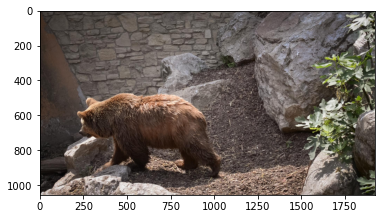

In [48]:
vote_refinement()

# Using max:

In [49]:
def vote_max():
    def voting_max(var, eash, sk, comb):
        final = np.zeros((row, col), np.uint8)
        count = 0
        for i in range(row):
            for j in range(col):
                count += 1
                syn = var[i][j]
                warp = eash[i][j]
                refine = sk[i][j]
                combined = comb[i][j]
                all_same = check_all_same(syn, warp, refine, combined)
                if all_same:
                    final[i][j] = refine
                    continue
                three_same, pix = check_3_same(syn, warp, refine, combined)
                if three_same and (pix != -1):
                    final[i][j] = pix
                    continue
                final[i][j] = max(syn, warp, refine, combined)
        print(count)
        return final

    final_r = voting_max(var_r, eash_r, sk_r, comb_r)
    final_g = voting_max(var_g, eash_g, sk_g, comb_g)
    final_b = voting_max(var_b, eash_b, sk_b, comb_b)
    voted = cv2.merge((final_r, final_g, final_b))
    voted = cv2.cvtColor(voted, cv2.COLOR_BGR2RGB)
    cv2.imwrite(f"{TEST_DATA}/voted-max.png", voted)
    vote = cv2.cvtColor(cv2.imread(f"{TEST_DATA}/voted-max.png"), cv2.COLOR_BGR2RGB)
    plt.imshow(vote)
    gt = cv2.cvtColor(cv2.imread(f"{TEST_DATA}/gt.png"), cv2.COLOR_BGR2RGB)
    img = cv2.cvtColor(cv2.imread(f"{TEST_DATA}/voted-max.png"), cv2.COLOR_BGR2RGB)
    calculateMetrics(gt, img)

2027520
2027520
2027520
MSE: 5.935392005997475
PSNR: 40.396309534291184
SSIM: 0.9779674708446159%


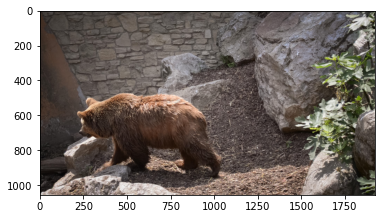

In [50]:
vote_max()

# Using min:

In [51]:
def vote_min():
    def voting_min(var, eash, sk, comb):
        final = np.zeros((row, col), np.uint8)
        count = 0
        for i in range(row):
            for j in range(col):
                count += 1
                syn = var[i][j]
                warp = eash[i][j]
                refine = sk[i][j]
                combined = comb[i][j]
                all_same = check_all_same(syn, warp, refine, combined)
                if all_same:
                    final[i][j] = refine
                    continue
                three_same, pix = check_3_same(syn, warp, refine, combined)
                if three_same and (pix != -1):
                    final[i][j] = pix
                    continue
                final[i][j] = min(syn, warp, refine, combined)
        print(count)
        return final

    final_r = voting_min(var_r, eash_r, sk_r, comb_r)
    final_g = voting_min(var_g, eash_g, sk_g, comb_g)
    final_b = voting_min(var_b, eash_b, sk_b, comb_b)
    voted = cv2.merge((final_r, final_g, final_b))
    voted = cv2.cvtColor(voted, cv2.COLOR_BGR2RGB)
    cv2.imwrite(f"{TEST_DATA}/voted-min.png", voted)
    vote = cv2.cvtColor(cv2.imread(f"{TEST_DATA}/voted-min.png"), cv2.COLOR_BGR2RGB)
    plt.imshow(vote)
    gt = cv2.cvtColor(cv2.imread(f"{TEST_DATA}/gt.png"), cv2.COLOR_BGR2RGB)
    img = cv2.cvtColor(cv2.imread(f"{TEST_DATA}/voted-min.png"), cv2.COLOR_BGR2RGB)
    calculateMetrics(gt, img)

2027520
2027520
2027520
MSE: 6.699777231954966
PSNR: 39.87019998247846
SSIM: 0.9725122380569678%


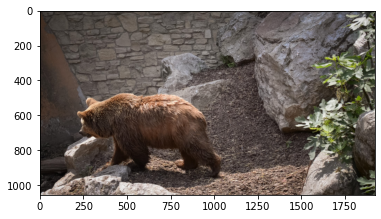

In [52]:
vote_min()

# Using warping:

In [53]:
def vote_warp():
    def voting_warp(var, eash, sk, comb):
        final = np.zeros((row, col), np.uint8)
        count = 0
        for i in range(row):
            for j in range(col):
                count += 1
                syn = var[i][j]
                warp = eash[i][j]
                refine = sk[i][j]
                combined = comb[i][j]
                all_same = check_all_same(syn, warp, refine, combined)
                if all_same:
                    final[i][j] = refine
                    continue
                three_same, pix = check_3_same(syn, warp, refine, combined)
                if three_same and (pix != -1):
                    final[i][j] = pix
                    continue
                final[i][j] = warp
        print(count)
        return final

    final_r = voting_warp(var_r, eash_r, sk_r, comb_r)
    final_g = voting_warp(var_g, eash_g, sk_g, comb_g)
    final_b = voting_warp(var_b, eash_b, sk_b, comb_b)
    voted = cv2.merge((final_r, final_g, final_b))
    voted = cv2.cvtColor(voted, cv2.COLOR_BGR2RGB)
    cv2.imwrite(f"{TEST_DATA}/voted-warp.png", voted)
    vote = cv2.cvtColor(cv2.imread(f"{TEST_DATA}/voted-warp.png"), cv2.COLOR_BGR2RGB)
    plt.imshow(vote)
    gt = cv2.cvtColor(cv2.imread(f"{TEST_DATA}/gt.png"), cv2.COLOR_BGR2RGB)
    img = cv2.cvtColor(cv2.imread(f"{TEST_DATA}/voted-warp.png"), cv2.COLOR_BGR2RGB)
    calculateMetrics(gt, img)

2027520
2027520
2027520
MSE: 1.1873344447074916
PSNR: 47.38507293949872
SSIM: 0.9902726882670507%


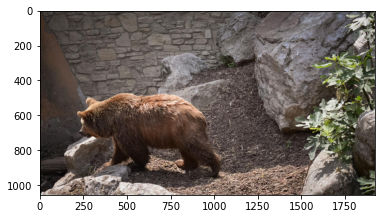

In [54]:
vote_warp()

# Using average:

In [55]:
def vote_average():
    def voting_avg(var, eash, sk, comb):
        final = np.zeros((row, col), np.uint8)
        count = 0
        for i in range(row):
            for j in range(col):
                count += 1
                syn = var[i][j]
                warp = eash[i][j]
                refine = sk[i][j]
                combined = comb[i][j]
                all_same = check_all_same(syn, warp, refine, combined)
                if all_same:
                    final[i][j] = refine
                    continue
                three_same, pix = check_3_same(syn, warp, refine, combined)
                if three_same and (pix != -1):
                    final[i][j] = pix
                    continue
                avg = ((syn + warp + refine + combined) / 4)
                final[i][j] = round(avg)
        print(count)
        return final

    final_r = voting_avg(var_r, eash_r, sk_r, comb_r)
    final_g = voting_avg(var_g, eash_g, sk_g, comb_g)
    final_b = voting_avg(var_b, eash_b, sk_b, comb_b)
    voted = cv2.merge((final_r, final_g, final_b))
    voted = cv2.cvtColor(voted, cv2.COLOR_BGR2RGB)
    cv2.imwrite(f"{TEST_DATA}/voted-avg.png", voted)
    vote = cv2.cvtColor(cv2.imread(f"{TEST_DATA}/voted-avg.png"), cv2.COLOR_BGR2RGB)
    plt.imshow(vote)
    gt = cv2.cvtColor(cv2.imread(f"{TEST_DATA}/gt.png"), cv2.COLOR_BGR2RGB)
    img = cv2.cvtColor(cv2.imread(f"{TEST_DATA}/voted-avg.png"), cv2.COLOR_BGR2RGB)
    calculateMetrics(gt, img)

C:\Users\varoo\AppData\Local\Temp\ipykernel_8872\3204238623.py:20: RuntimeWarning: overflow encountered in ubyte_scalars
  avg = ((syn + warp + refine + combined) / 4)


2027520
2027520
2027520
MSE: 35.99787030460858
PSNR: 32.568035529427306
SSIM: 0.2452723793168121%


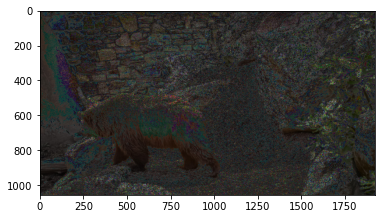

In [56]:
vote_average()

# Using combined pixels:

In [57]:
def vote_combined():
    def voting_combine(var, eash, sk, comb):
        final = np.zeros((row, col), np.uint8)
        count = 0
        for i in range(row):
            for j in range(col):
                count += 1
                syn = var[i][j]
                warp = eash[i][j]
                refine = sk[i][j]
                combined = comb[i][j]
                all_same = check_all_same(syn, warp, refine, combined)
                if all_same:
                    final[i][j] = refine
                    continue
                three_same, pix = check_3_same(syn, warp, refine, combined)
                if three_same and (pix != -1):
                    final[i][j] = pix
                    continue
                final[i][j] = combined
        print(count)
        return final

    final_r = voting_combine(var_r, eash_r, sk_r, comb_r)
    final_g = voting_combine(var_g, eash_g, sk_g, comb_g)
    final_b = voting_combine(var_b, eash_b, sk_b, comb_b)
    voted = cv2.merge((final_r, final_g, final_b))
    voted = cv2.cvtColor(voted, cv2.COLOR_BGR2RGB)
    cv2.imwrite(f"{TEST_DATA}/voted-combined.png", voted)
    vote = cv2.cvtColor(cv2.imread(f"{TEST_DATA}/voted-combined.png"), cv2.COLOR_BGR2RGB)
    plt.imshow(vote)
    gt = cv2.cvtColor(cv2.imread(f"{TEST_DATA}/gt.png"), cv2.COLOR_BGR2RGB)
    img = cv2.cvtColor(cv2.imread(f"{TEST_DATA}/voted-combined.png"), cv2.COLOR_BGR2RGB)
    calculateMetrics(gt, img)

2027520
2027520
2027520
MSE: 10.687062519728535
PSNR: 37.842220108305405
SSIM: 0.953390486966765%


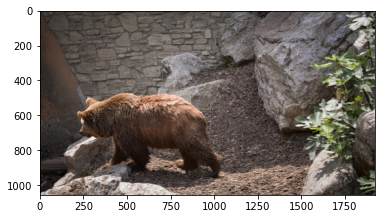

In [58]:
vote_combined()

# Original result:

In [77]:
gt = cv2.cvtColor(cv2.imread(f"{TEST_DATA}/gt.png"), cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(cv2.imread(f"{TEST_DATA}/sk.png"), cv2.COLOR_BGR2RGB)
calculateMetrics(gt, img)

MSE: 0.9095081147693452
PSNR: 48.54273782609884
SSIM: 0.9933171562169534%


In [78]:
def vote_RefWarp():
    def voting_avg(var, eash, sk, comb):
        final = np.zeros((row, col), np.uint8)
        count = 0
        for i in range(row):
            for j in range(col):
                count += 1
                syn = var[i][j]
                warp = eash[i][j]
                refine = sk[i][j]
                combined = comb[i][j]
                all_same = check_all_same(syn, warp, refine, combined)
                if all_same:
                    final[i][j] = refine
                    continue
                three_same, pix = check_3_same(syn, warp, refine, combined)
                if three_same and (pix != -1):
                    final[i][j] = pix
                    continue
                avg = ((warp + refine) / 2)
                final[i][j] = round(avg)
        print(count)
        return final

    final_r = voting_avg(var_r, eash_r, sk_r, comb_r)
    final_g = voting_avg(var_g, eash_g, sk_g, comb_g)
    final_b = voting_avg(var_b, eash_b, sk_b, comb_b)
    voted = cv2.merge((final_r, final_g, final_b))
    voted = cv2.cvtColor(voted, cv2.COLOR_BGR2RGB)
    cv2.imwrite(f"{TEST_DATA}/voted-RefWarp.png", voted)
    vote = cv2.cvtColor(cv2.imread(f"{TEST_DATA}/voted-RefWarp.png"), cv2.COLOR_BGR2RGB)
    plt.imshow(vote)
    gt = cv2.cvtColor(cv2.imread(f"{TEST_DATA}/gt.png"), cv2.COLOR_BGR2RGB)
    img = cv2.cvtColor(cv2.imread(f"{TEST_DATA}/voted-RefWarp.png"), cv2.COLOR_BGR2RGB)
    calculateMetrics(gt, img)

C:\Users\varoo\AppData\Local\Temp\ipykernel_8872\2743628599.py:20: RuntimeWarning: overflow encountered in ubyte_scalars
  avg = ((warp + refine) / 2)


114688
114688
114688
MSE: 0.7688802083333334
PSNR: 49.272216789498884
SSIM: 0.961502698596753%


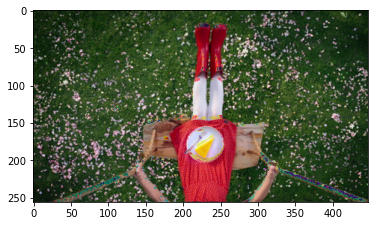

In [79]:
vote_RefWarp()